<a href="https://colab.research.google.com/github/springboardmentor1361k/Smart-Energy-Consumption-Analysis-and-Prediction-using-Machine-Learning-with-Device-Level-Insights-/blob/KARAN-S/milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install tensorflow gradio scikit-learn pandas numpy matplotlib


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import gradio as gr


In [43]:
df = pd.read_csv("smart_home_energy_consumption_large.csv")

df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('timestamp')

df.rename(columns={'Energy Consumption (kWh)': 'energy'}, inplace=True)

df.head()


,Home ID,Appliance Type,energy,Time,Date,Outdoor Temperature (°C),Season,Household Size,timestamp
51495,140,Lights,1.00,00:07,2023-01-01,-5.9,Winter,1,2023-01-01 00:07:00
26489,298,Lights,1.09,00:13,2023-01-01,22.0,Winter,1,2023-01-01 00:13:00
8690,469,Fridge,0.30,00:24,2023-01-01,-1.2,Winter,3,2023-01-01 00:24:00
33315,398,Fridge,0.50,00:26,2023-01-01,35.8,Winter,2,2023-01-01 00:26:00
93438,293,Washing Machine,1.12,00:30,2023-01-01,2.7,Winter,3,2023-01-01 00:30:00


In [44]:
device_dfs = {}

for device in df['Appliance Type'].unique():
    temp = df[df['Appliance Type'] == device]
    temp = temp.groupby('timestamp')['energy'].sum().reset_index()
    temp.set_index('timestamp', inplace=True)
    temp = temp.resample('H').sum().fillna(0)
    device_dfs[device] = temp


/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp = temp.resample('H').sum().fillna(0)
/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp = temp.resample('H').sum().fillna(0)
/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp = temp.resample('H').sum().fillna(0)
/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp = temp.resample('H').sum().fillna(0)
/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp = temp.resample('H').sum().fillna(0)
/tmp/ipython-input-339291855.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please

In [45]:
def create_sequences(data, window=48):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)


In [46]:
def build_strong_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )

    return model


In [47]:
WINDOW = 48

device_models = {}
device_scalers = {}
device_metrics = {}

for device, ddf in device_dfs.items():
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(ddf[['energy']])

    X, y = create_sequences(scaled, WINDOW)
    split = int(0.8 * len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_strong_lstm((WINDOW, 1))

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5)
    ]

    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=0
    )

    preds = model.predict(X_test)

    y_test_inv = scaler.inverse_transform(y_test)
    preds_inv = scaler.inverse_transform(preds)

    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    r2 = r2_score(y_test_inv, preds_inv)

    device_models[device] = model
    device_scalers[device] = scaler
    device_metrics[device] = (rmse, mae, r2)

    print(f"{device} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Lights → RMSE: 1.25, MAE: 1.03, R²: -0.005
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Fridge → RMSE: 0.35, MAE: 0.28, R²: -0.000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Washing Machine → RMSE: 1.24, MAE: 1.01, R²: -0.000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Microwave → RMSE: 1.31, MAE: 1.04, R²: -0.000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Dishwasher → RMSE: 1.34, MAE: 1.09, R²: -0.015
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Air Conditioning → RMSE: 3.84, MAE: 3.07, R²: -0.002
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
TV → RMSE: 1.27, MAE: 1.02, R²: -0.002
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Computer → RMSE: 1.27, MAE: 1.03, R²: -0.004
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Heater → RMSE: 3.70, MAE: 2.92, R²: -0.002
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Oven → RMSE: 1.31, MAE: 1.04, R²: -0.001


In [48]:
for device, model in device_models.items():
    model.save(f"{device}_lstm_model.h5")


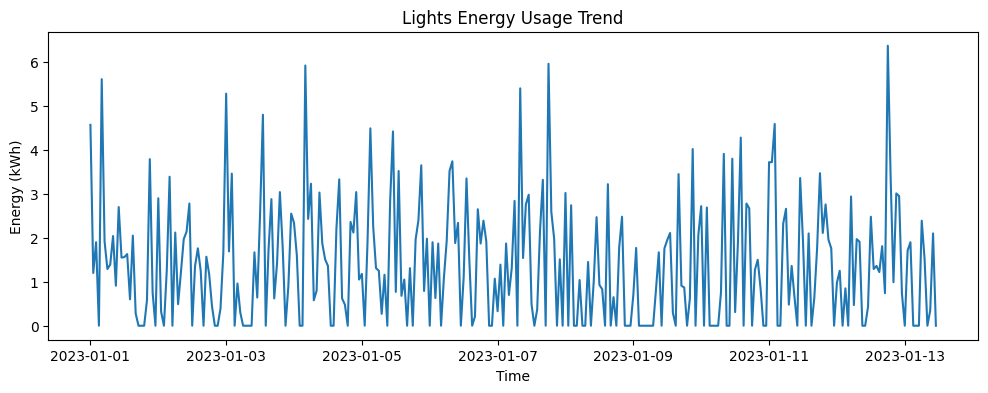

In [49]:
sample_device = list(device_dfs.keys())[0]
ddf = device_dfs[sample_device]

plt.figure(figsize=(12,4))
plt.plot(ddf['energy'][:300])
plt.title(f"{sample_device} Energy Usage Trend")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.show()


In [50]:
def predict_device(device, *inputs):
    model = device_models[device]
    scaler = device_scalers[device]

    seq = np.array(inputs).reshape(1, WINDOW, 1)
    seq_scaled = scaler.transform(seq.reshape(-1,1)).reshape(1, WINDOW, 1)

    pred = model.predict(seq_scaled)
    return float(scaler.inverse_transform(pred)[0][0])


In [51]:
def get_sample(device):
    return device_dfs[device]['energy'].iloc[-WINDOW:].values.tolist()


In [ ]:
device_list = list(device_models.keys())
sample = get_sample(device_list[0])

inputs = [
    gr.Dropdown(device_list, label="Appliance Type")
] + [
    gr.Number(label=f"Hour {i+1}", value=sample[i]) for i in range(WINDOW)
]

app = gr.Interface(
    fn=predict_device,
    inputs=inputs,
    outputs=gr.Number(label="Predicted Next-Hour Energy (kWh)"),
    title="Device-Wise Smart Energy Consumption Prediction",
    description="High-accuracy LSTM model for appliance-level energy forecasting"
)

app.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6c6e74a51b0636ea9d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
